In [13]:
# packages

# use internal plotting styles
try:
    import artlo
    from artlo import plt
except:
    import matplotlib as mpl
    import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import elapid as ela
from scipy.stats import gaussian_kde

# preference
try:
    artlo.plot.set_style('salo-light')
except:
    mpl.style.use('ggplot')

In [5]:
# paths
base = "/Users/christopher/src/cfo-big-trees/data"

plots = os.path.join(base, "plots")
raster = os.path.join(base, "raster")
vector = os.path.join(base, "vector")

raster_paths = [
    "SierraEcoregion-Elevation-DEM-Summer-2020-00030m.tif",
    "SierraEcoregion-Disturbance-Management-2020-Summer-00030m.tif",
    "SierraEcoregion-Disturbance-TimeSinceFire-2020-Summer-00030m.tif",
    "SierraEcoregion-Vegetation-AbovegroundCarbonDensity-2020-Spring-00030m.tif",
    "SierraEcoregion-Vegetation-CanopyHeight-2020-Spring-00030m.tif",
    "SierraEcoregion-Vegetation-TallTrees-2020-Spring-00030m.tif",
    "SierraEcoregion-Wildfire-ScaledHazard-2020-Summer-00030m.tif",
    "ecoregion_model_current_mean.tif",
    "ecoregion_model_rcp45_mean.tif",
    "ecoregion_model_rcp85_mean.tif",
    "ecoregion_model_current_stdv.tif",
    "ecoregion_model_rcp45_stdv.tif",
    "ecoregion_model_rcp85_stdv.tif",
]
rasters = [os.path.join(raster, path) for path in raster_paths]

labels = [
    "Elevation",
    "Slope",
    "Aspect",
    "YearsSinceManagement",
    "YearsSinceFire",
    "AbovegroundCarbonDensity",
    "CanopyHeight",
    "IsTall",
    "Hazard",
    "SuitabilityCurrent",
    "SuitabilityRCP45",
    "SuitabilityRCP85",
    "SuitabilityCurrentSTDV",
    "SuitabilityRCP45STDV",
    "SuitabilityRCP85STDV",
]
points = os.path.join(vector, "point-samples-all.gpkg")

## Reading and cleaning data

In [9]:
# set this to True to re-run the data labeling
rerun = False
points_labeled = os.path.join(vector, 'point-samples-annotated-hazard.csv')

if rerun:
    # annotation
    df = gpd.read_file(points)
    df = ela.annotate(df, rasters, labels=labels)

    # remove geometry column
    df = df.drop(columns=['geometry'])
    
    # remove non-vegetated pixels
    has_trees = df['CanopyHeight'] > 0
    df = df[has_trees]
    df.reset_index(drop=True)

    # save for later
    df.to_csv(points_labeled)

else:
    df = pd.read_csv(points_labeled)

# set variables for indexing tall/non-tall pixels
is_tall = df['IsTall'] == 1
not_tall = df['IsTall'] == 0

## Basic Histogram Plotting

In [12]:
# frequency distributions plotting routine
def density_dist(ydata,plot=None,fill=True,fill_alpha=0.3,label=None,linewidth=2,xlabel=None,
                 ylabel="Relative Frequency",xlim=None,ylim=None,covar=0.25,cutoff=2, colors=None, **kwargs,
):
    # handle uneven sample sizes
    if type(ydata) is list:
        ncol = len(ydata)

    # handle numpy arrays
    elif type(ydata) is np.ndarray:
        # if the ndarray is only 1-d, convert it to a list
        if ydata.ndim == 1:
            ydata = [ydata]
        # otherwise, loop through each column and assign as unique items in list
        else:
            newdata = []
            for i in range(ydata.shape[1]):
                newdata.append(ydata[:, i])
            ydata = newdata
        ncol = len(ydata)
    else:
        print("[ ERROR ]: unsupported ydata format. must be a list or np.ndarray")

    if not plot:
        plot = plt

    # handle labels
    if label is not None:
        if type(label) is str:
            label = list(label)
        else:
            if len(label) < ncol:
                print("[ ERROR ]: number of labels specified doesn't match number of columns")
                label = []
                for i in range(ncol):
                    label.append(None)
    else:
        label = []
        for i in range(ncol):
            label.append(None)

    if colors is None:
        colors = [None for _ in range(ncol)]

    # find the min/max range for plot based on %cutoff
    if not xlim:
        xmin = []
        xmax = []
        for i in range(ncol):
            xmin.append(np.percentile(np.array(ydata[i]), cutoff))
            xmax.append(np.percentile(np.array(ydata[i]), 100 - cutoff))
        xlim = [min(xmin), max(xmax)]

    # set the x plot size
    xs = np.linspace(xlim[0], xlim[1])

    # loop through each feature, calculate the covariance, and plot
    for i in range(ncol):
        dns = gaussian_kde(np.array(ydata[i]))
        dns.covariance_factor = lambda: covar
        dns._compute_covariance()
        ys = dns(xs)

        # plotting functions
        color = colors[i]
        plot.plot(xs, ys, label=label[i], linewidth=linewidth, color=color, **kwargs)
        if fill:
            plot.fill_between(xs, ys, alpha=fill_alpha, color=color)

    # finalize other meta plot routines
    plot.xlabel(xlabel)
    plot.ylabel(ylabel)
    if label[0] is not None:
        plot.legend(fancybox=True)
    plot.tight_layout()

    # return the final object object for further manipulation
    return plot

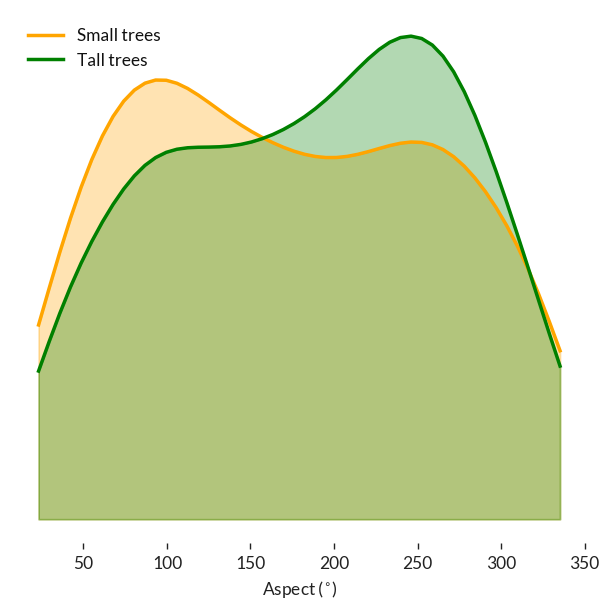

In [22]:
# exploratory plotting
var = 'Aspect'
units = '^{\circ}'
labels = ["Small Trees", "Tall Trees"]
colors = ["gray", "orange"]
bins = 10

# plotting
#plt.figure(figsize=(4,4), dpi=125)
#plt.hist(
#    [df[not_tall][var], df[is_tall][var]],
#    density=True,
#    color=colors,
#    bins=bins,
#    label=labels,
#    log=False
#)
density_dist(
    [df[not_tall][var], df[is_tall][var]],
    label=["Small trees", "Tall trees"],
    colors=["orange", "green"],
    ylabel=None,
)

# labels
plt.xlabel(f"{var} (${units}$)")
plt.ylabel(None)
plt.yticks([], [])

# figure
plt.legend(fancybox=True)
plt.tight_layout()
plt.savefig(os.path.join(plots, f"hist-istall-{var}.png"), dpi=150)

# Carbon content

Though Tall Trees occupy a small fraction of the total area (here, 10%), they store a disporportionately large amount of carbon. How much relative to the total carbon stocks are stored within areas with tall trees?

In [14]:
# compute the area per pixel in hectares
area_per_pixel = (30 * 30) / (100 * 100)

# average carbon densities
acd_is_tall = df[is_tall]['AbovegroundCarbonDensity']
acd_not_tall = df[not_tall]['AbovegroundCarbonDensity']
acd_is_tall_mean = acd_is_tall.mean()
acd_not_tall_mean = acd_not_tall.mean()

# total area per group
area_is_tall = len(acd_is_tall) * area_per_pixel
area_not_tall = len(acd_not_tall) * area_per_pixel

# total carbon
carbon_is_tall = int(area_is_tall * acd_is_tall_mean)
carbon_not_tall = int(area_not_tall * acd_not_tall_mean)
total_carbon = carbon_is_tall + carbon_not_tall
fraction_tall_carbon = 100 * (carbon_is_tall / total_carbon)

print(f"Total carbon: {total_carbon:,} Mg C")
print(f"Tall tree carbon: {carbon_is_tall:,} Mg C")
print(f"Percent carbon in tall trees: {fraction_tall_carbon:0.1f}%")

Total carbon: 553,859 Mg C
Tall tree carbon: 146,143 Mg C
Percent carbon in tall trees: 26.4%


## Hazard binning

Wildfire hazard percentiles describe the relative hazard across the region, and it doesn't look like there are uniform differences in hazard scores between areas with and without tall trees. This doesn't mean that there are no regions without high hazards, however.

Where are the areas with high hazard scores? What environmental differences emerge between low, moderate, and high hazard areas?

In [23]:
# mapping
high_hazard = df['Hazard'] > 66
low_hazard = df['Hazard'] < 33
mid_hazard = ~high_hazard * ~low_hazard

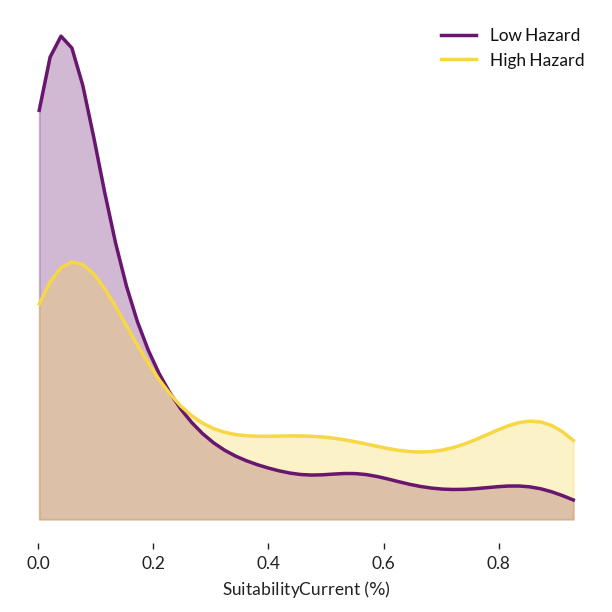

In [26]:
# exploratory plotting
var = 'SuitabilityCurrent'
units = '\%'
labels = ["Low Hazard", "High Hazard"]
colors = ["#69166e", "#f6d746"]
bins = 10

# plotting
"""
plt.figure(figsize=(4,4), dpi=125)
plt.hist(
    [df[low_hazard][var], df[high_hazard][var]],
    density=True,
    color=colors,
    bins=bins,
    label=labels,
    log=False
)
"""
density_dist(
    [df[low_hazard][var], df[high_hazard][var]],
    label=labels,
    colors=colors,
    ylabel=None,
)

# labels
plt.xlabel(f"{var} (${units}$)")
plt.ylabel(None)
plt.yticks([], [])

# figure
plt.legend(fancybox=True)
plt.tight_layout()
plt.savefig(plots + f"hist-hazard-{var}.png", dpi=150)

## Future bioclimatic suitability binning

We have a range of future climatic suitability scores

In [ ]:
# suitability change
diff_rcp45 = df['SuitabilityRCP45'] - df['SuitabilityCurrent']
diff_rcp85 = df['SuitabilityRCP85'] - df['SuitabilityCurrent']

# use the sum of 3x the standard deviations to flag significant change
margin_rcp45 = 3*df['SuitabilityRCP45STDV'] + 3*df['SuitabilityCurrentSTDV']
margin_rcp85 = 3*df['SuitabilityRCP85STDV'] + 3*df['SuitabilityCurrentSTDV']

# negative change
#neg_rcp45 = (df['SuitabilityRCP45'] + 3*df['SuitabilityRCP45STDV']) - (df['SuitabilityCurrent'] - 3*df['SuitabilityCurrentSTDV']) < 0
#neg_rcp85 = (df['SuitabilityRCP85'] + 3*df['SuitabilityRCP85STDV']) - (df['SuitabilityCurrent'] - 3*df['SuitabilityCurrentSTDV']) < 0
neg_rcp45 = diff_rcp45 < -margin_rcp45
neg_rcp85 = diff_rcp85 < -margin_rcp85
neg_rcp45_pct = 100 * (neg_rcp45.sum() / len(neg_rcp45))
neg_rcp85_pct = 100 * (neg_rcp85.sum() / len(neg_rcp85))

print("Negative suitability change:")
print(f"RCP45: {neg_rcp45_pct:0.1f}%, RCP85: {neg_rcp85_pct:0.1f}%")

# positive change
#pos_rcp45 = (df['SuitabilityRCP45'] - 3*df['SuitabilityRCP45STDV']) - (df['SuitabilityCurrent'] + 3*df['SuitabilityCurrentSTDV']) > 0
#pos_rcp85 = (df['SuitabilityRCP85'] - 3*df['SuitabilityRCP85STDV']) - (df['SuitabilityCurrent'] + 3*df['SuitabilityCurrentSTDV']) > 0
pos_rcp45 = diff_rcp45 > margin_rcp45
pos_rcp85 = diff_rcp85 > margin_rcp85
pos_rcp45_pct = 100 * (pos_rcp45.sum() / len(pos_rcp45))
pos_rcp85_pct = 100 * (pos_rcp85.sum() / len(pos_rcp85))

print("Positive suitability change:")
print(f"RCP45: {pos_rcp45_pct:0.1f}%, RCP85: {pos_rcp85_pct:0.1f}%")

# Add change data to df, add binary maps
df['SuitabilityRCP45Change'] = diff_rcp45
df['SuitabilityRCP85Change'] = diff_rcp85

# and estimate where no change occurs
null_rcp45 = ~neg_rcp45 * ~pos_rcp45
null_rcp85 = ~neg_rcp85 * ~pos_rcp85

In [ ]:
# exploratory plotting
var = 'AbovegroundCarbonDensity'
units = 'MgC \cdot ha^{-1}'
labels = ["Suitability decrease", "Suitability increase"]
colors = ["purple", "green"]
bins = 10

# plotting
plt.figure(figsize=(4,4), dpi=125)
plt.hist(
    [df[neg_rcp85][var], df[pos_rcp85][var]],
    density=True,
    color=colors,
    bins=bins,
    label=labels,
    log=False
)

# labels
plt.xlabel(f"{var} (${units}$)")
plt.ylabel(None)
plt.yticks([], [])

# figure
plt.legend(fancybox=True)
plt.tight_layout()
plt.savefig(plots + f"hist-change_rcp85-{var}.png", dpi=150)